# **Trabalho Prático 3: Métodos Numéricos (M2039)**

**Autores:**
* Eduardo Moura - up202406710
* Filipe Zheng - up202406753
* João Azevedo - up202404140
* Manuel Mota - up202403543

---

## **Introdução**

Este trabalho tem como objetivo a aplicação e análise comparativa de métodos de interpolação polinomial e segmentada. Especificamente, comparamos o **Polinómio Interpolador de Newton** com o **Spline Cúbico Natural**.

O estudo foca-se na precisão, suavidade e estabilidade numérica, analisando o comportamento do erro nas extremidades do intervalo (Fenómeno de Runge) e a adequação dos métodos a dados físicos (evaporação).

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
from decimal import Decimal, ROUND_CEILING

# Configuração estética dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


def round_error(error:float)->str:  # Função usada para arredondar o erro para cima e representar com dois algarismos significativos
  error = f"{error:e}"
  error_rounded = f"{math.ceil(float(error[:-4])*10)/10}{error[-4:]}"
  return error_rounded
def format_result(raiz,erro):
  if isinstance(erro,float): erro = round_error(erro)
  return f"{raiz:0.0{int(erro[-2:])+1}f} ± {erro}"

## **Exercício 1**

Considera-se a função $f(x) = x^2 + \sin(6x)$ definida no intervalo $[-1, 1]$.

### **1.a) Definição dos Pontos de Interpolação**

Pretende-se construir um conjunto de $n+1 = 8$ pontos equidistantes.
O passo $h$ é dado por:
$$h = \frac{b-a}{n} = \frac{1 - (-1)}{7} = \frac{2}{7}$$

Os nós são definidos por $x_i = -1 + i \cdot h$ para $i=0, \dots, 7$.

In [19]:
# Definição da função f(x)
def f(x):
    return x**2 + np.sin(6*x)

# 1.a) Construção dos 8 pontos (n=7)
n = 7
a, b = -1, 1
x_pontos = np.linspace(a, b, n + 1)
y_pontos = f(x_pontos)

print("Pontos de suporte (xi, yi):")
for xi, yi in zip(x_pontos, y_pontos):
    print(f"x: {xi: .4f}, y: {yi: .4f}")

Pontos de suporte (xi, yi):
x: -1.0000, y:  1.2794
x: -0.7143, y:  1.4206
x: -0.4286, y: -0.3561
x: -0.1429, y: -0.7356
x:  0.1429, y:  0.7764
x:  0.4286, y:  0.7234
x:  0.7143, y: -0.4001
x:  1.0000, y:  0.7206


### **1.b) Construção dos Interpoladores**

#### **i. Polinómio Interpolador (Forma de Newton)**
O polinómio interpolador de grau $n$, $p_n(x)$, é único. Utilizamos a **Forma de Newton** baseada em diferenças divididas. A fórmula é dada por:

$$p_n(x) = f[x_0] + \sum_{k=1}^n f[x_0, \dots, x_k] \prod_{j=0}^{k-1}(x-x_j)$$

Onde os coeficientes são as diferenças divididas de ordem $k$.

#### **ii. Spline Cúbico Natural**
Um spline cúbico $S(x)$ é composto por polinómios de grau 3, $S_i(x)$, definidos em cada subintervalo $[x_i, x_{i+1}]$. O spline garante continuidade da função, da primeira derivada e da segunda derivada nos nós internos.

Para construir o spline, definimos os momentos $M_i = S''(x_i)$ como as segundas derivadas nos nós.
Para um **Spline Natural**, impomos curvatura nula nas extremidades:
$$M_0 = 0 \quad \text{e} \quad M_n = 0$$

Para determinar os momentos internos $M_1, \dots, M_{n-1}$, resolvemos um sistema linear tridiagonal derivado da continuidade de $S'(x)$. Sendo $h_i = x_{i+1} - x_i$, a equação para cada nó interno $i$ é:

$$
h_{i-1}M_{i-1} + 2(h_{i-1} + h_i)M_i + h_iM_{i+1} = 6 \left( \frac{y_{i+1}-y_i}{h_i} - \frac{y_i - y_{i-1}}{h_{i-1}} \right)
$$

Isto resulta num sistema linear da forma $A\mathbf{M} = \mathbf{b}$, onde $A$ é uma matriz tridiagonal de dimensão $(n-1) \times (n-1)$:

$$
\begin{bmatrix}
2(h_0+h_1) & h_1 & 0 & \dots \\
h_1 & 2(h_1+h_2) & h_2 & \dots \\
\vdots & \ddots & \ddots & \ddots \\
0 & \dots & h_{n-2} & 2(h_{n-2}+h_{n-1})
\end{bmatrix}
\begin{bmatrix}
M_1 \\
M_2 \\
\vdots \\
M_{n-1}
\end{bmatrix}
=
\begin{bmatrix}
6(f[x_1, x_2] - f[x_0, x_1]) \\
6(f[x_2, x_3] - f[x_1, x_2]) \\
\vdots \\
6(f[x_{n-1}, x_n] - f[x_{n-2}, x_{n-1}])
\end{bmatrix}
$$

Uma vez resolvido este sistema para obter os valores de $M$, o spline em cada intervalo $[x_{i-1}, x_{i}]$ é dado por:
$$
S_i(x) = \frac{M_{i-1}(x_{i}-x)^3 + M_{i}(x-x_{i-1})^3}{6h_{i}} + \left(y_{i-1} - \frac{M_{i-1} h_{i}^2}{6}\right)\frac{x_{i}-x}{h_{i}} + \left(y_{i} - \frac{M_{i} h_{i}^2}{6}\right)\frac{x-x_{i-1}}{h_i}
$$

In [20]:
# === Método de Newton (Diferenças Divididas) ===
def diferencas_divididas(x_points, y_points):
    n = len(x_points)
    coef = np.zeros([n, n])
    coef[:, 0] = y_points

    for j in range(1, n):
        for i in range(n - j):
            # f[xi...xi+j] = (f[xi+1...xi+j] - f[xi...xi+j-1]) / (x_{i+j} - x_i)
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x_points[i + j] - x_points[i])
    coef = coef[0, :] # Primeira linha (coeficientes)

    def newton_poly(x_eval):  # Definição do polinómio
      if isinstance(x_eval,np.ndarray): return np.array([newton_poly(val) for val in x_eval]) # Se receber um array de valores, aplicar a função a todos os valores
      nonlocal coef,x_points
      n = len(x_points) - 1
      p = coef[n]
      for k in range(1, n + 1):
          p = coef[n - k] + (x_eval - x_points[n - k]) * p
      return p
    return newton_poly



# === Spline Cúbico Natural ===
def spline_cubico_natural(x_points, y_points):
    N = len(x_points) - 1
    h = np.diff(x_points) # Vetor de passos h_i

    # 1. Montagem do Sistema Linear A * M = b
    # Dimensão do sistema interno é (N-1) pois M_0=0 e M_N=0
    A = np.zeros((N-1, N-1))
    b = np.zeros(N-1)

    for i in range(1, N):
        idx = i - 1

        # Lado direito (Diferenças divididas de 2ª ordem multiplicadas por 6)
        term1 = (y_points[i+1] - y_points[i]) / h[i]
        term2 = (y_points[i] - y_points[i-1]) / h[i-1]
        b[idx] = 6 * (term1 - term2) # O fator 6 é comum na literatura para simplificar a matriz

        # Diagonal Principal: 2(h_{i-1} + h_i)
        A[idx, idx] = 2 * (h[i-1] + h[i])

        # Diagonais secundárias: h_i
        if idx > 0:
            A[idx, idx-1] = h[i-1]
        if idx < N-2:
            A[idx, idx+1] = h[i]

    # 2. Resolução do Sistema (usando biblioteca linear apenas aqui)
    M_interior = np.linalg.solve(A, b)

    # Condições de fronteira natural
    M = np.concatenate(([0], M_interior, [0]))

    # 3. Avaliação do Spline
    def spline(x_eval): # Definição do spline
      if isinstance(x_eval,np.ndarray): return np.array([spline(val) for val in x_eval])
      nonlocal y_points,M,x_points
      for i in range(1, N + 1):
          if x_points[i-1] <= x_eval <= x_points[i]:
              hi = h[i-1]
              # Fórmula do Spline Cúbico usando os Momentos M
              term1 = (M[i-1] * (x_points[i] - x_eval)**3) / (6 * hi)
              term2 = (M[i] * (x_eval - x_points[i-1])**3) / (6 * hi)
              term3 = (y_points[i-1] - (M[i-1] * hi**2) / 6) * (x_points[i] - x_eval) / hi
              term4 = (y_points[i] - (M[i] * hi**2) / 6) * (x_eval - x_points[i-1]) / hi
              return term1 + term2 + term3 + term4
      return np.nan
    return spline

Métrica              | Polinómio       | Spline         
--------------------------------------------------------
Erro Máximo          | 0.30            | 0.097          


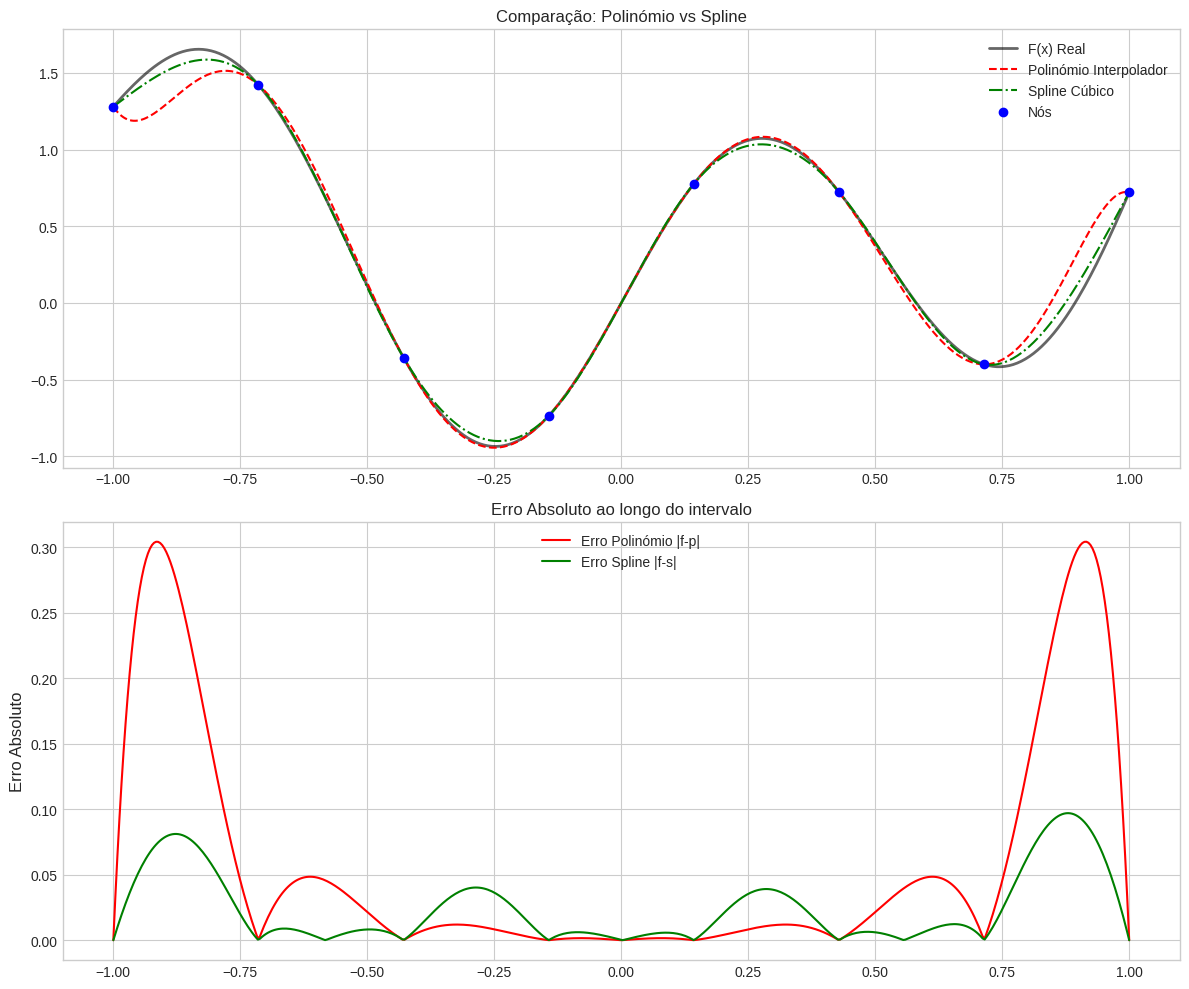

In [21]:
# Cálculo dos modelos
polinomio = diferencas_divididas(x_pontos, y_pontos)
spline = spline_cubico_natural(x_pontos, y_pontos)

# Malha fina para visualização
xx = np.linspace(-1, 1, 500)
ff = f(xx)
pp = polinomio(xx)
ss = spline(xx)

# --- Análise Numérica de Erros (Demonstração Quantitativa) ---
erro_p_abs = np.abs(ff - pp)
erro_s_abs = np.abs(ff - ss)

print(f"{'Métrica':<20} | {'Polinómio':<15} | {'Spline':<15}")
print("-" * 56)
print(f"{'Erro Máximo':<20} | {np.max(erro_p_abs):<15.2f} | {np.max(erro_s_abs):<15.3f}")

# --- Gráficos ---
plt.figure(figsize=(12, 10))

# Gráfico das Funções
plt.subplot(2, 1, 1)
plt.plot(xx, ff, 'k-', alpha=0.6, linewidth=2, label='F(x) Real')
plt.plot(xx, pp, 'r--', label='Polinómio Interpolador')
plt.plot(xx, ss, 'g-.', label='Spline Cúbico')
plt.scatter(x_pontos, y_pontos, c='blue', label='Nós', zorder=5)
plt.title("Comparação: Polinómio vs Spline")
plt.legend()

# Gráfico dos Erros
plt.subplot(2, 1, 2)
plt.plot(xx, erro_p_abs, 'r', label='Erro Polinómio |f-p|')
plt.plot(xx, erro_s_abs, 'g', label='Erro Spline |f-s|')
plt.title("Erro Absoluto ao longo do intervalo")
plt.ylabel("Erro Absoluto")
plt.legend()

plt.tight_layout()
plt.show()

### **Análise Detalhada dos Resultados (Ex 1.b)**

A análise dos gráficos e dos erros numéricos permite-nos tirar conclusões importantes sobre o comportamento de cada método:

1.  **Instabilidade do Polinómio (Fenómeno de Runge):**
    Observando o gráfico das funções (painel superior) e o gráfico dos erros (painel inferior, linha vermelha), nota-se que o polinómio interpolador de Newton (grau $n=7$) oscila significativamente nas extremidades do intervalo $[-1, 1]$.
    Isto ocorre porque a interpolação polinomial é um método **global**: o ajuste num único ponto influencia o polinómio em todo o domínio. Quando usamos nós equidistantes, polinómios de grau elevado tendem a acumular erro nas extermidades, conhecido como **Fenómeno de Runge**.

2.  **Estabilidade e Suavidade do Spline:**
    O Spline Cúbico Natural (linha verde) mantém-se estável e suave em todo o domínio. Isto deve-se à sua natureza **local**: é definido por diferentes polinómios cúbicos em cada subintervalo, o que impede que oscilações numa região se propaguem para todo o domínio. Além disso, o Spline Cúbico tem a propriedade matemática de **minimizar a curvatura global** ($\int |S''(x)|^2 dx$), garantindo a curva mais suave possível que passa pelos pontos.

3.  **Conclusão sobre o Erro:**
    O gráfico de erros revela que, embora no centro do intervalo ($x \approx 0$) ambos os métodos tenham precisão comparável, nas extremidades o erro do polinómio dispara, tornando-se muito superior ao do spline.
    
    Erro Máximo:
        
    * Polinómio: 0.30

    * Spline: 0.097       

### **1.c) Majorantes de Erro Teóricos**

Vamos calcular os majorantes em $x=0.1$ e $x=0.9$.

#### **Fórmulas de Erro:**

1.  **Polinómio ($n=7$):**
    
    Para $n=7$, precisamos da 8ª derivada de $f(x) = x^2 + \sin(6x)$.
    * $f'(x) = 2x + 6\cos(6x)$
    * $f''(x) = 2 - 36\sin(6x)$
    * $f^{(3)}(x) = -216\cos(6x)$
    * $f^{(4)}(x) = 6^4\sin(6x)$
    * ...
    * $f^{(8)}(x) = 6^8 \sin(6x)$
    $$|E_n(x)| \le \frac{\max |f^{(8)}(\xi)|}{8!} \left| \prod_{i=0}^{7} (x - x_i) \right|$$
    *Nota:* O máximo da derivada de ordem 8 é $6^8$.

2.  **Spline Cúbico:**
    $$|E_s(x)| \le \frac{5}{384} \max |f^{(4)}(\xi)| h^4$$
    *Nota:* A derivada de ordem 4 é $f^{(4)}(x) = 6^4\sin(6x)$. O máximo é $6^4$. O passo $h = 2/7$.

#### **Porquê 0.1 e 0.9?**
A escolha destes pontos ilustra a estabilidade dos métodos:
* **$x=0.1$ (Centro):** O termo produtorio $\prod(x-x_i)$ é muito pequeno perto do centro. O polinómio deve ser preciso.
* **$x=0.9$ (Extermidade):** Nas extremidades, o termo produtorio cresce drasticamente. O polinómio deve falhar (Fenómeno de Runge), enquanto o Spline deve manter a precisão (pois depende de $h$, que é constante).

In [24]:
# Parâmetros
x_vals = [0.1, 0.9]
h = 2/7
max_f8 = 6**8  # Max de f^(8)
max_f4 = 6**4  # Max de f^(4)

print(f"""Valor reais:
  f(0.1) = {f(0.1)}
  f(0.9) = {f(0.9)}
  """)

print(f"{'x':<5} | {'Método':<10} | {'Erro Real':<12} | {'Majorante Teórico':<20} | Valor de de f(x)")
print("-" * 80)

for val in x_vals:
    f_real = f(val)
    f_poly = polinomio(val)
    f_spline = spline(val)

    # Erros reais
    err_p_real = abs(f_real - f_poly)

    err_p_real = round_error(err_p_real)

    err_s_real = abs(f_real - f_spline)

    err_s_real = round_error(err_s_real)

    # Cálculo do termo produtorio para o polinómio
    prod_term = np.prod([abs(val - xi) for xi in x_pontos])

    # Majorantes teóricos
    # Polinómio: (max|f^8| / 8!) * prod |x-xi|
    maj_poly = (max_f8 / math.factorial(8)) * prod_term

    maj_poly = round_error(maj_poly)

    # Spline: (5/384) * max|f^4| * h^4
    maj_spline = (5/384) * max_f4 * (h**4)

    maj_spline = round_error(maj_spline)

    print(f"{val:<5} | {'Newton':<10} | {err_p_real:<12} | {maj_poly:<20} | {format_result(f_poly,maj_poly)}")
    print(f"{val:<5} | {'Spline':<10} | {err_s_real:<12} | {maj_spline:<20} | {format_result(f_spline,maj_spline)}")
    print("-" * 80)

Valor reais:
  f(0.1) = 0.5746424733950355
  f(0.9) = 0.03723551244401291
  
x     | Método     | Erro Real    | Majorante Teórico    | Valor de de f(x)
--------------------------------------------------------------------------------
0.1   | Newton     | 1.5e-03      | 3.8e-02              | 0.573 ± 3.8e-02
0.1   | Spline     | 5.6e-03      | 1.2e-01              | 0.58 ± 1.2e-01
--------------------------------------------------------------------------------
0.9   | Newton     | 3.0e-01      | 1.2e+00              | 0.3 ± 1.2e+00
0.9   | Spline     | 9.5e-02      | 1.2e-01              | 0.13 ± 1.2e-01
--------------------------------------------------------------------------------


### **Análise dos Erros e Comparação com as Previsões Teóricas**

Os resultados numéricos obtidos na célula anterior confirmam as previsões teóricas estabelecidas em 1.c):

1.  **Comportamento no Centro ($x=0.1$):**
    * O Erro Real do Polinómio ($1.5 \times 10^{-3}$) é inferior ao do Spline ($5.6 \times 10^{-3}$).
    * Isto acontece porque, no centro do intervalo, o termo produtorio $\prod |x-x_i|$ na fórmula do erro polinomial é muito pequeno, permitindo uma precisão elevada localmente.
    * Ambos os erros reais estão abaixo dos seus respetivos majorantes teóricos ($3.8 \times 10^{-2}$ para o Polinómio e $1.2 \times 10^{-1}$ para o Spline).

2.  **Comportamento na Extremidade ($x=0.9$):**
    * **Polinómio:** O Erro Real aumenta drasticamente para $3.0 \times 10^{-1}$, aproximando-se da ordem de grandeza do seu majorante teórico ($1.2 \times 10^{0}$). Isto valida o **Fenómeno de Runge**: nas extermidades, o produto das distâncias aos nós cresce, degradando severamente a aproximação (a distância aos outros pontos acumula-se, fazendo o majorante crescer muito).
    * **Spline:** O Erro Real ($9.5 \times 10^{-2}$) mantém-se controlado e abaixo do majorante ($1.2 \times 10^{-1}$). O erro do Spline é mais estável ao longo do domínio porque o seu majorante depende apenas do passo $h$ (constante) e não da posição $x$.

**Conclusão:** O Polinómio é instável, apresentando erros que variam enormemente dependendo da posição (muito bom no centro, muito mau nas pontas). O Spline é robusto, garantindo um erro limitado e previsível em todo o intervalo.

## **Exercício 2: Evaporação da Água**

Análise de dados experimentais mensais usando Polinómios e Splines.

**Objetivo:** Determinar qual a aproximação fisicamente mais aceitável e identificar **artefactos numéricos**.

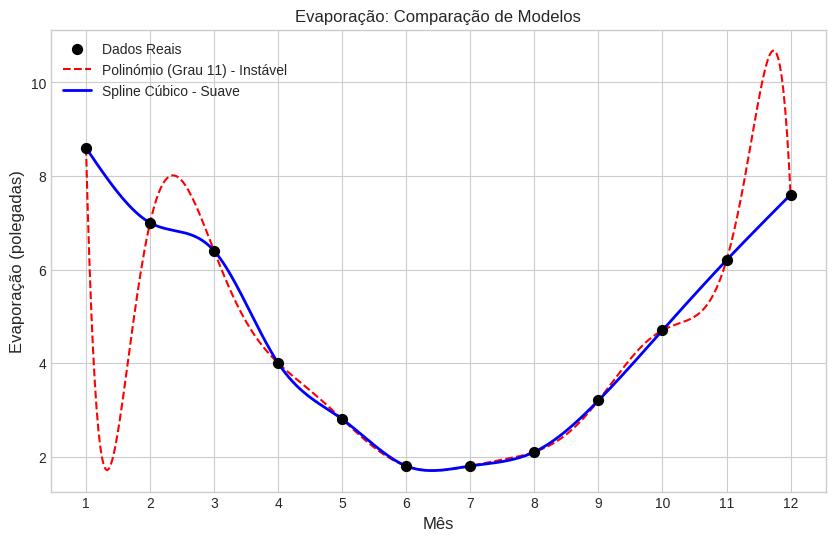

In [23]:
# Dados
meses = np.array(range(1, 13)) # 1 a 12
evap = np.array([8.6, 7.0, 6.4, 4.0, 2.8, 1.8, 1.8, 2.1, 3.2, 4.7, 6.2, 7.6])

# 1. Polinómio (Grau 11) e Spline
polinomio_evap = diferencas_divididas(meses, evap)
spline_evap = spline_cubico_natural(meses, evap)

# 2. Gráficos
xx_meses = np.linspace(1, 12, 400)
p_evap = polinomio_evap(xx_meses)
s_evap = spline_evap(xx_meses)

plt.figure(figsize=(10, 6))
plt.scatter(meses, evap, color='black', s=50, label='Dados Reais', zorder=5)
plt.plot(xx_meses, p_evap, 'r--', label='Polinómio (Grau 11) - Instável')
plt.plot(xx_meses, s_evap, 'b-', linewidth=2, label='Spline Cúbico - Suave')

plt.title("Evaporação: Comparação de Modelos")
plt.xlabel("Mês")
plt.ylabel("Evaporação (polegadas)")
plt.legend()
plt.xticks(meses)
plt.show()

### **2.b) Qual das duas aproximações é mais aceitável?**

A aproximação pelo **Spline Cúbico Natural** é a mais aceitável.

**Justificação:**

1.  **Coerência Física:** A evaporação da água é um processo físico contínuo e gradual, dependente de fatores sazonais (temperatura, humidade) que variam suavemente ao longo do ano. O gráfico do Spline reflete esta suavidade, apresentando transições lógicas entre os meses.

2.  **Ausência de Oscilações Artificiais:** Ao analisarmos o gráfico do Polinómio Interpolador (linha vermelha), observamos flutuações bruscas e "barrigas" acentuadas entre os pontos tabelados especialmente nas extremidades (por exemplo, a oscilação entre Janeiro e Fevereiro representa uma descida e subida rapida na evaporação não lógico como o verão na austrália dura de dezembro até fevereiro). Estas oscilações não possuem significado físico; são **artefactos numéricos** gerados pela natureza do polinómio de grau elevado ($n=11$), que se "esforça" excessivamente para cruzar todos os pontos, perdendo a estabilidade nos intervalos.

3.  **O Fenómeno de Runge:**
    A instabilidade observada no polinómio é uma manifestação clássica do **Fenómeno de Runge**.
    * Temos um conjunto de 12 pontos com abcissas **equidistantes** (os meses). Isto obriga à construção de um polinómio de grau $n=11$.
    * No contexto da **Aproximação Numérica**, sabe-se que, para nós equidistantes, aumentar o grau do polinómio não garante a diminuição do erro máximo; pelo contrário, tende a provocar oscilações violentas, especialmente nas extremidades do intervalo.
    * O **Spline Cúbico** evita este problema estruturalmente: em vez de aumentar o grau para $n=11$, utiliza múltiplos polinómios de grau baixo (3) conectados com continuidade $C^2$, garantindo um ajuste preciso sem as oscilações patológicas do método global.